In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img

from keras import backend as K
import keras

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import threading
import pickle

Using TensorFlow backend.


In [2]:
train_path = "dashcam/frames/training/positive"
test_path = "dashcam/frames/testing/positive"

frames_path = {}

train_data = []
test_data = []

In [3]:
def make_sequences(frames, mode):
    
    frames = sorted(frames)
    sequences = []

    for i in range(0, 100, 25):
        sequence = frames[i:(i + 25)]
        if i < 75:
            label = np.zeros(25)
        else:
            label = np.concatenate((np.zeros(15), np.ones(10)), axis = 0)
        item = sequence, label
        if(mode == "train"):
            train_data.append(item)
        elif(mode == "test"):
            test_data.append(item)

In [4]:
for category in ["train", "test"]:
    data_path = train_path if category == "train" else test_path
    
    for video in os.listdir(data_path):
        frames = []
        for frame in os.listdir(data_path + "/" + video):
            frames.append(video + "_" + frame)
            frames_path[video + "_" + frame] = data_path + "/" + video
        if len(frames) == 100:
            make_sequences(frames, category)

In [5]:
def image_to_tensor(filename):
  
    tokens = filename.split("_")
    im = load_img(frames_path[filename] + "/frame_" + tokens[2], target_size = (256, 256))
    im = img_to_array(im)
    im =  im / 255.
    #plt.imshow(im.astype(np.uint8))

    return im

In [6]:
def sequence_prep(sequence):
  
    x, y = sequence

    images = []

    for filename in x:
        im = image_to_tensor(filename)
        images.append(im)

    images = np.array(images)  # (25, 256, 256, 3)
    labels = np.reshape(y, (images.shape[0], 1))   # (25, 1)

    return images, labels

In [7]:
def batch_prep(batch):
  
    batch_x = []
    batch_y = []

    for sequence in batch:
        images, labels = sequence_prep(sequence)
        batch_x.append(images)
        batch_y.append(labels)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    
    return batch_x, batch_y

In [8]:
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [9]:
@threadsafe_generator
def data_generator(mode):
    
    data = train_data if mode == "train" else test_data
    np.random.shuffle(data)
  
    batch_size = 10
    nb_batch = len(data) // batch_size
    
    print("Mode: " + mode + " => data generator in work to produce: " + str(nb_batch) + " batches from " + str(len(data)) + " data instances. ")

    while True:
        for i in range(nb_batch):

            beg = i * batch_size
            end = (i * batch_size + batch_size) if i * batch_size < len(data) else -1

            batch = data[beg : end]

            batch_x, batch_y = batch_prep(batch)
            
            inp = batch_x[:, :20, :, :, :]  
            out = batch_y[:, 20:25, :]

            yield inp, out

In [10]:
def weighted_binary_crossentropy( y_true, y_pred, weight = 9.) :
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

In [11]:
shape = (256, 256, 3)
n_units = 512
resnet = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=shape, pooling="max")
resnet.trainable = False
for layer in resnet.layers:
    layer.trainable = False
inp = Input(shape)
f = resnet(inp)
f = Dense(n_units , activation='relu')(f)
resnet = Model(inputs = inp , outputs = f , name="resnet_f")

resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
Total params: 24,636,800
Trainable params: 1,049,088
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
enc_time_step = 20
dec_time_step = 5

encoder1 = LSTM(n_units , return_sequences=True  , name="encoder1")
encoder2 = LSTM(n_units , return_sequences=True  , name="encoder2")
encoder3 = LSTM(n_units , return_state=True, name="encoder3")

decoder1 = LSTM(n_units , return_sequences=True  , name="decoder1")
decoder2 = LSTM(n_units , return_sequences=True  , name="decoder2")
decoder3 = LSTM(n_units , return_sequences=True  , return_state= True, name="decoder3")

decoder_dense1 = Dense(32 , activation = "relu")
decoder_dense2 =  Dense(1 , activation =  "sigmoid")

In [13]:
encoder_input = Input((enc_time_step,)+shape)
cnn_features = TimeDistributed(resnet)(encoder_input)
enc = encoder1(cnn_features)
enc = encoder2(enc)
encoder_output , state_h , state_c = encoder3(cnn_features)

encoder_model = Model(inputs = encoder_input , outputs = [encoder_output , state_h , state_c])

repeat_enco = RepeatVector(dec_time_step)(encoder_output)
dec = decoder1(repeat_enco , initial_state=[state_h , state_c])
dec = decoder2(dec)
decoder_outputs  , _ , _ = decoder3(dec)

decoder_outputs = TimeDistributed(decoder_dense1)(TimeDistributed(Dropout(rate = 0.2))(decoder_outputs))
decoder_outputs = TimeDistributed(decoder_dense2)(TimeDistributed(Dropout(rate = 0.2))(decoder_outputs))

seq2seq_model = Model(inputs = [encoder_input] , outputs = [decoder_outputs])
seq2seq_model.summary()

optimizer = Adam(lr=0.001)
metrics = ['accuracy']
seq2seq_model.compile(loss=[weighted_binary_crossentropy], optimizer=optimizer, metrics=metrics)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20, 256, 256, 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 20, 512)      24636800    input_3[0][0]                    
__________________________________________________________________________________________________
encoder3 (LSTM)                 [(None, 512), (None, 2099200     time_distributed_1[0][0]         
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 512)       0           encoder3[0][0]              

In [ ]:
checkpoint = ModelCheckpoint(
        filepath=os.path.join('saved_models', 'seq2seq_no_encoded_prior', 'model_seq2seq' + \
            '.{epoch:03d}-{loss:.3f}.hdf5'),
        verbose=1,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)

train_datagen = data_generator("train")
test_datagen = data_generator("test")

seq2seq_model.load_weights("saved_models/seq2seq_3/model_seq2seq.017-1.702.hdf5")

history = seq2seq_model.fit_generator(generator = train_datagen, steps_per_epoch = 182, epochs = 30, verbose = 1, workers = 4, shuffle = False, callbacks = [checkpoint], validation_data = test_datagen, validation_steps = 60, initial_epoch = 0)

In [ ]:
pickle_out = open("saved_models/seq2seq_no_encoded_prior/history_dashcam_seq2seq_e30.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [56]:
pickle_in = open("saved_models/seq2seq_no_encoded_prior/history_seq2seq_no_encoded_prior_e20.pickle","rb")
loaded_history = pickle.load(pickle_in)

val_loss = loaded_history["val_loss"]
val_acc = loaded_history["val_acc"]

training_loss = loaded_history["loss"]
training_acc = loaded_history["acc"]

epochs = range(20)

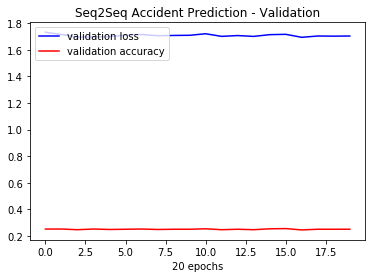

In [57]:
plt.plot(epochs, val_loss, '-b', label='validation loss')
plt.plot(epochs, val_acc, '-r', label='validation accuracy')

plt.xlabel("20 epochs")
plt.legend(loc='upper left')
plt.title("Seq2Seq Accident Prediction - Validation")

plt.savefig("figures/seq2seq_no_encoded_prior_e20_val" + ".png")  
plt.show()

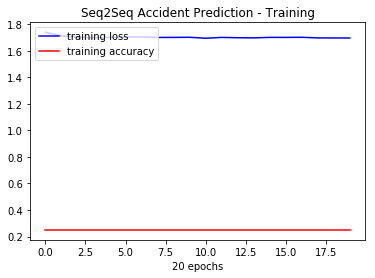

In [58]:
plt.plot(epochs, training_loss, '-b', label='training loss')
plt.plot(epochs, training_acc, '-r', label='training accuracy')

plt.xlabel("20 epochs")
plt.legend(loc='upper left')
plt.title("Seq2Seq Accident Prediction - Training")

plt.savefig("figures/seq2seq_no_encoded_prior_e20_train" + ".png")  
plt.show()

In [14]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    seq2seq_model.load_weights("saved_models/seq2seq_no_encoded_prior/seq2seq_no_encoded_prior.017-1.702.hdf5")
    
    for i in range(0, 100, 25):
        predictions = []
        input_sequence = frames[i : i + 20]
        input_sequence = np.array([input_sequence])
        pred = seq2seq_model.predict(input_sequence)
        pred = np.reshape(pred, (5, 1))      
        for i in pred:
            predictions.append(i[0])
        print(predictions)

    plt.plot(range(100), predictions, '-b', label='activations')
    plt.ylabel("Final activations")
    plt.xlabel("Frames - " + file_idx)
    plt.title("Seq2Seq accident prediction - Inference")
    plt.show()

[0.7071624, 0.7029689, 0.70243526, 0.7020857, 0.704016]
[0.707175, 0.702973, 0.70243645, 0.70209193, 0.7040203]
[0.70718616, 0.702975, 0.70243764, 0.70209044, 0.70401883]
[0.70719945, 0.7029719, 0.70243555, 0.7020836, 0.70401233]


ValueError: x and y must have same first dimension, but have shapes (100,) and (5,)

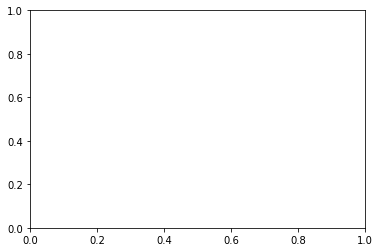

In [15]:
model_inference("dashcam/frames/testing/positive/000508")